In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-vgg19-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = VGG19(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 158s 17ms/step - loss: 14.6320 - acc: 0.0894 - val_loss: 14.6700 - val_acc: 0.0898
Epoch 2/100
9112/9112 [==============================] - 148s 16ms/step - loss: 14.6676 - acc: 0.0900 - val_loss: 14.6700 - val_acc: 0.0898
Epoch 3/100
9114/9114 [==============================] - 145s 16ms/step - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 65/100
9114/9114 [==============================] - 145s 16ms/step - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 66/100
9114/9114 [==============================] - 145s 16ms/step - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 67/100
9114/9114 [==============================] - 146s 16ms/step - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 68/100
9114/9114 [==============================] - 145s 16ms/step - loss: 15.7060 - acc: 0.0256 - val_

Epoch 57/100
9120/9120 [==============================] - 147s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 58/100
9120/9120 [==============================] - 148s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 59/100
9120/9120 [==============================] - 147s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 60/100
9120/9120 [==============================] - 147s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 61/100
9120/9120 [==============================] - 147s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 62/100
9120/9120 [==============================] - 148s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 63/100
9120/9120 [==============================] - 147s 16ms/step - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 64/100


9125/9125 [==============================] - 147s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 15/100
9125/9125 [==============================] - 147s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 16/100
9125/9125 [==============================] - 148s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 17/100
9125/9125 [==============================] - 147s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 18/100
9125/9125 [==============================] - 147s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 19/100
9125/9125 [==============================] - 148s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 20/100
9125/9125 [==============================] - 148s 16ms/step - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 21/100
9125/9125 [==

In [21]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.1030


In [22]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

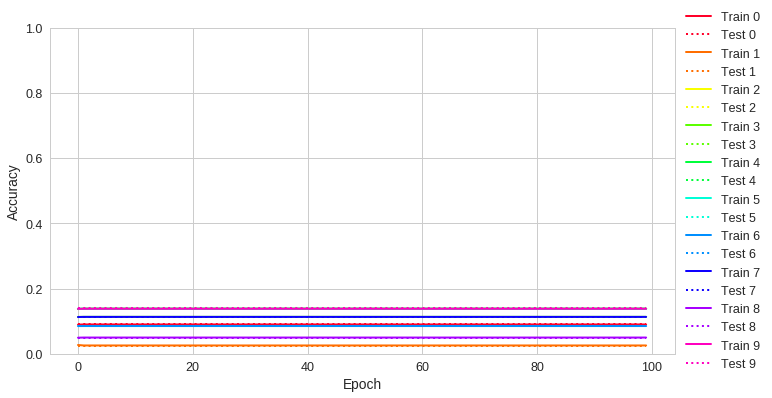

In [23]:
plot_acc(history)

In [24]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

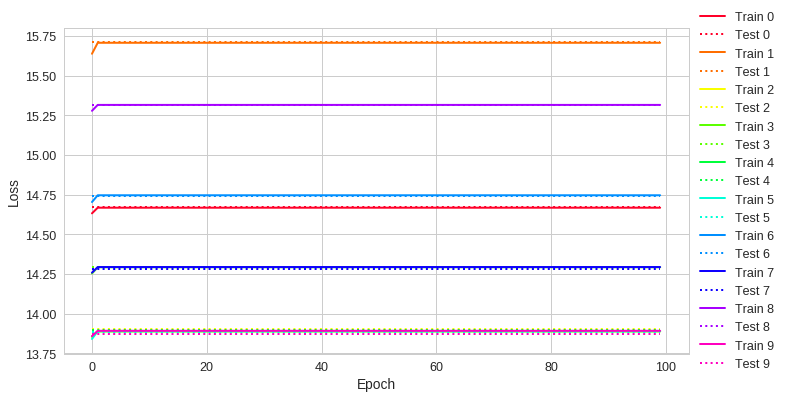

In [25]:
plot_loss(history)

Plotting the confusion matrix


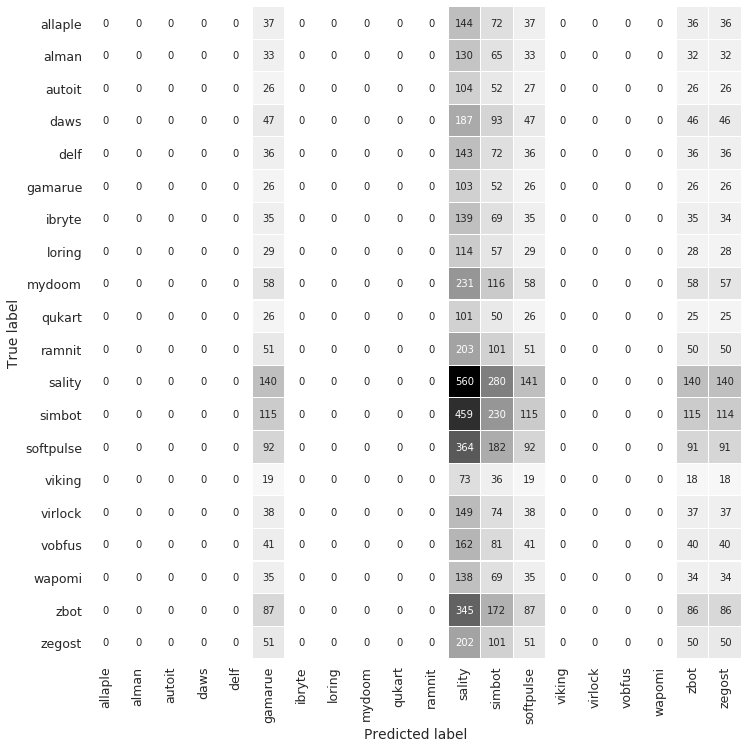

In [26]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


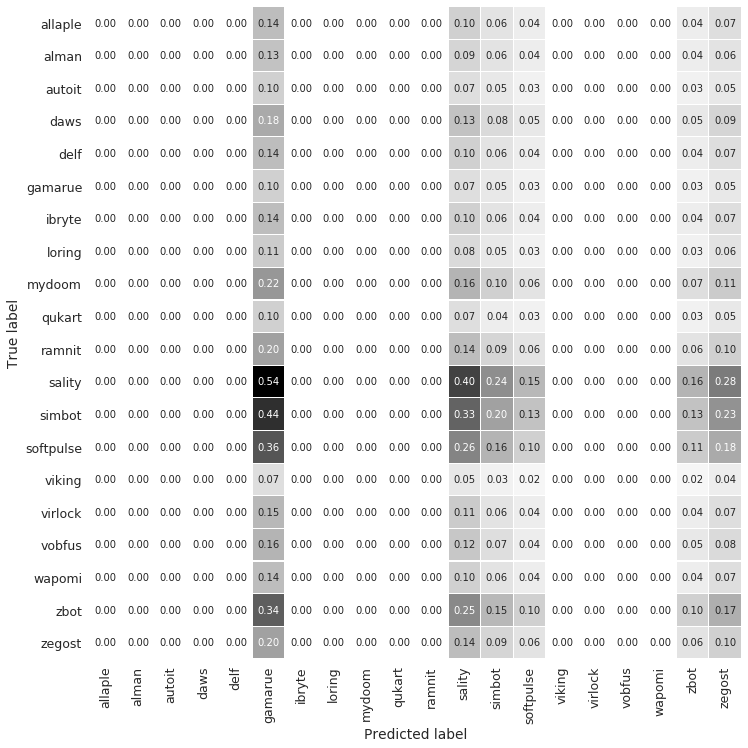

In [27]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
for h in history:
    print(h.history)

{'val_loss': [14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

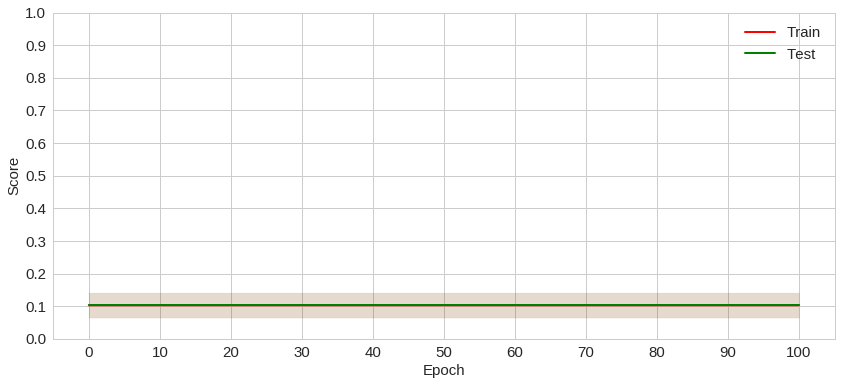

In [30]:
plot_mean_acc(history)

In [31]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

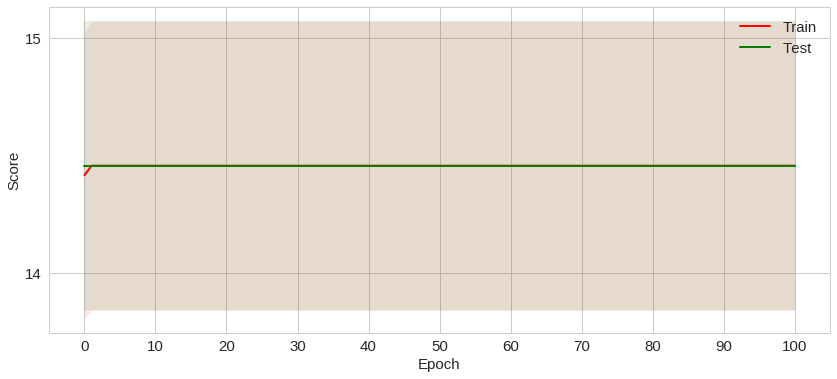

In [32]:
plot_mean_loss(history)

In [34]:
hist = [{'val_loss': [14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977, 14.669985242187977], 'val_acc': [0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375, 0.08984375], 'loss': [14.632025271575634, 14.667608096999386, 14.66760813049102, 14.66760811207062, 14.66760810955875, 14.667608107046876, 14.667608140538512, 14.66760812044353, 14.667608169006401, 14.66760811960624, 14.66760812044353, 14.667608065182332, 14.667608088626476, 14.667608098673966, 14.667608088626476, 14.667608086951894, 14.667608117094366, 14.667608108721458, 14.667608108721458, 14.66760807439253, 14.667608103697713, 14.667608096999386, 14.667608115419785, 14.667608107046876, 14.667608103697713, 14.667608132165602, 14.667608118768948, 14.667608142213092, 14.667608146399548, 14.667608155609747, 14.66760813970122, 14.667608107046876, 14.667608108721458, 14.667608088626476, 14.66760812881644, 14.667608105372294, 14.667608103697713, 14.667608127141857, 14.667608096999386, 14.667608093650221, 14.667608090301059, 14.667608113745203, 14.667608142213092, 14.66760813049102, 14.667608141375801, 14.667608095324804, 14.667608094487512, 14.667608078578986, 14.667608133840185, 14.667608098673966, 14.667608152260584, 14.667608100348549, 14.667608100348549, 14.667608090301059, 14.667608146399548, 14.667608095324804, 14.667608060995878, 14.667608088626476, 14.66760810202313, 14.667608095324804, 14.66760813886393, 14.66760811123333, 14.667608105372294, 14.667608105372294, 14.667608076067113, 14.66760814723684, 14.667608083602731, 14.667608107046876, 14.667608118768948, 14.667608122118112, 14.66760814723684, 14.66760812881644, 14.667608096999386, 14.667608108721458, 14.667608098673966, 14.667608107046876, 14.66760811207062, 14.66760808192815, 14.667608118768948, 14.667608143887675, 14.66760812044353, 14.667608135514765, 14.667608093650221, 14.667608142213092, 14.667608098673966, 14.667608118768948, 14.66760810202313, 14.667608143887675, 14.667608076067113, 14.667608089463767, 14.66760810202313, 14.667608145562257, 14.667608105372294, 14.667608105372294, 14.667608090301059, 14.667608090301059, 14.66760812881644, 14.667608137189347, 14.667608107046876, 14.667608110396039], 'acc': [0.08944249341527656, 0.08999122037201518, 0.08999122036874452, 0.08999122037528584, 0.08999122038182718, 0.08999122036874452, 0.08999122036874452, 0.08999122037201518, 0.08999122036874452, 0.08999122038182718, 0.08999122037201518, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122036874452, 0.08999122037201518, 0.08999122036874452, 0.08999122037528584, 0.08999122036874452, 0.08999122036874452, 0.08999122037201518, 0.08999122037528584, 0.08999122037201518, 0.08999122037201518, 0.08999122036874452, 0.08999122037528584, 0.08999122036874452, 0.08999122038182718, 0.08999122037528584, 0.08999122038182718, 0.08999122037201518, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122039490985, 0.08999122037201518, 0.08999122037201518, 0.08999122037201518, 0.08999122037201518, 0.08999122037201518, 0.08999122037201518, 0.08999122037528584, 0.08999122037201518, 0.08999122036874452, 0.08999122036874452, 0.08999122036874452, 0.08999122037528584, 0.08999122037201518, 0.08999122036874452, 0.08999122037528584, 0.08999122036874452, 0.08999122037201518, 0.08999122037201518, 0.08999122038182718, 0.08999122039490985, 0.08999122036874452, 0.08999122037528584, 0.08999122036874452, 0.08999122037528584, 0.08999122037528584, 0.08999122036874452, 0.08999122037528584, 0.08999122037528584, 0.08999122038182718, 0.08999122037201518, 0.08999122037201518, 0.08999122037201518, 0.08999122037528584, 0.08999122036874452, 0.08999122036874452, 0.0899912204210752, 0.08999122037201518, 0.08999122039490985, 0.08999122037528584, 0.08999122037201518, 0.08999122036874452, 0.08999122037528584, 0.08999122037528584, 0.08999122037201518, 0.08999122036874452, 0.08999122037528584, 0.08999122037201518, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122037201518, 0.08999122038182718, 0.08999122038182718, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122037528584, 0.08999122036874452, 0.08999122037201518, 0.08999122037528584, 0.08999122037201518, 0.08999122037201518, 0.08999122037201518]},
{'val_loss': [15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296, 15.708046105043296], 'val_acc': [0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987], 'loss': [15.636977673937203, 15.70603506905692, 15.70603506905692, 15.706035065708491, 15.706035067382706, 15.706035072405347, 15.706035070731135, 15.706035062360062, 15.706035070731135, 15.70603506905692, 15.706035060685847, 15.706035065708491, 15.706035075753777, 15.706035070731135, 15.706035070731135, 15.706035060685847, 15.706035070731135, 15.706035064034277, 15.70603508077642, 15.706035070731135, 15.706035067382706, 15.706035064034277, 15.706035075753777, 15.706035067382706, 15.706035060685847, 15.706035079730036, 15.706035074079562, 15.70603506905692, 15.706035072405347, 15.706035082450635, 15.706035082450635, 15.706035070731135, 15.706035066336321, 15.706035072405347, 15.706035062360062, 15.706035064034277, 15.706035059011635, 15.706035074079562, 15.706035067382706, 15.70603505733742, 15.706035068010536, 15.706035079102206, 15.706035072405347, 15.706035074079562, 15.70603506905692, 15.706035060685847, 15.706035060685847, 15.706035087473277, 15.706035067382706, 15.706035082450635, 15.706035067382706, 15.706035060685847, 15.706035060685847, 15.706035064034277, 15.706035062360062, 15.706035077427991, 15.70603506968475, 15.706035075753777, 15.706035074079562, 15.70603506968475, 15.706035059639465, 15.706035064034277, 15.706035076381607, 15.706035064034277, 15.706035064034277, 15.706035077427991, 15.706035067382706, 15.706035067382706, 15.706035077427991, 15.706035067382706, 15.706035051268392, 15.706035064034277, 15.706035070731135, 15.706035072405347, 15.706035070731135, 15.70603506905692, 15.706035070731135, 15.70603506905692, 15.706035066964152, 15.706035077427991, 15.706035074079562, 15.706035070731135, 15.70603508077642, 15.706035077427991, 15.706035084124848, 15.706035070731135, 15.706035055663206, 15.706035070731135, 15.70603508077642, 15.70603506905692, 15.706035070731135, 15.706035064034277, 15.706035064034277, 15.706035090821706, 15.706035064034277, 15.706035072405347, 15.706035070731135, 15.706035097518562, 15.706035064034277, 15.70603506905692], 'acc': [0.026991441737985518, 0.025565064739659086, 0.025565064739659086, 0.025565064739659086, 0.02556506474374652, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.02556506474374652, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064758461296, 0.025565064735571647, 0.025565064739659086, 0.025565064739659086, 0.025565064739659086, 0.025565064739659086, 0.025565064735571647, 0.025565064758461296, 0.025565064739659086, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.02556506474374652, 0.025565064739659086, 0.025565064739659086, 0.02556506474374652, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064758461296, 0.025565064739659086, 0.025565064735571647, 0.025565064758461296, 0.025565064758461296, 0.025565064735571647, 0.025565064758461296, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.02556506474374652, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.02556506474374652, 0.025565064739659086, 0.025565064787890845, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.02556506474374652, 0.025565064735571647, 0.02556506474374652, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.02556506474374652, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086]},
{'val_loss': [13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122, 13.905807831708122], 'val_acc': [0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433], 'loss': [13.852982235247758, 13.88850800663612, 13.888508043042291, 13.888508033836134, 13.88850801374997, 13.888508012494585, 13.88850806647615, 13.888508040531521, 13.888508057269991, 13.888508023374591, 13.88850803299921, 13.888508037183827, 13.888508043460753, 13.888508019608434, 13.888508049319219, 13.888508095768472, 13.888508050574604, 13.888507996174576, 13.888508030069978, 13.888508007054583, 13.8885079970115, 13.8885079970115, 13.888508030069978, 13.888508009565353, 13.888508027140746, 13.888508036346904, 13.88850801626074, 13.888508053922298, 13.888508007473044, 13.888508046389987, 13.888508046389987, 13.888508026303823, 13.888508059780762, 13.888508036346904, 13.888508040949983, 13.88850804722691, 13.888508057269991, 13.888507993245344, 13.88850805685153, 13.888508033836134, 13.888508033836134, 13.888508056433068, 13.888508014586893, 13.88850804011306, 13.888507976088412, 13.888508033836134, 13.888508030069978, 13.888508023793053, 13.888507993245344, 13.888508012913046, 13.888507986968419, 13.88850798989765, 13.888508020026896, 13.888507986549957, 13.888508019189972, 13.888508023793053, 13.888508033417672, 13.888508012913046, 13.888508037183827, 13.888508056014606, 13.88850806647615, 13.888508015423817, 13.888508022956128, 13.888508033836134, 13.888508029651517, 13.888507935916085, 13.888508043879215, 13.8885080254669, 13.888507992826883, 13.88850803299921, 13.888508013331508, 13.888507986968419, 13.888507990316112, 13.888507992826883, 13.888508067313074, 13.888508043042291, 13.88850801626074, 13.888508020863819, 13.88850799952227, 13.888507976088412, 13.888508046808449, 13.88850804011306, 13.88850801374997, 13.88850804973768, 13.888508026303823, 13.888508046389987, 13.888508050156142, 13.888508003706889, 13.888508063965379, 13.888508020026896, 13.888508040531521, 13.888507990734574, 13.88850804011306, 13.88850804262383, 13.88850800621766, 13.888508019608434, 13.888508027140746, 13.888508027140746, 13.888508016679202, 13.888508009983815], 'acc': [0.13767003072830292, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821418131167, 0.1383282141339078, 0.13832821413881163, 0.13832821418131167, 0.13832821414861934, 0.13832821414861934, 0.1383282141551578, 0.13832821418131167, 0.13832821414861934, 0.1383282141551578, 0.1383282141339078, 0.13832821412900395, 0.13832821418131167, 0.1383282141551578, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821418131167, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821413881163, 0.1383282141551578, 0.13832821414208088, 0.13832821412900395, 0.1383282141551578, 0.13832821413881163, 0.13832821413881163, 0.13832821413881163, 0.1383282141551578, 0.13832821412900395, 0.13832821418131167, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821418131167, 0.13832821414208088, 0.1383282141551578, 0.13832821422054245, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821414208088, 0.13832821414861934, 0.1383282141551578, 0.13832821418131167, 0.13832821414861934, 0.13832821414861934, 0.13832821414861934, 0.1383282141339078, 0.13832821414208088, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.1383282141339078, 0.13832821413881163, 0.1383282141551578, 0.13832821413881163, 0.13832821414208088, 0.1383282141551578, 0.13832821413881163, 0.13832821414208088, 0.1383282142466963, 0.1383282141551578, 0.13832821413881163, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821413881163, 0.13832821414208088, 0.13832821413881163, 0.13832821413881163, 0.13832821413554242, 0.1383282141551578, 0.1383282141551578, 0.13832821414861934, 0.13832821414861934, 0.13832821414208088, 0.1383282141551578, 0.1383282141551578, 0.1383282141551578, 0.13832821414861934, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821418131167, 0.13832821413554242, 0.13832821414861934, 0.1383282141339078, 0.13832821413881163, 0.1383282141551578, 0.13832821414208088, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934]},
{'val_loss': [14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285, 14.293704667429285], 'val_acc': [0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275, 0.11318897637795275], 'loss': [14.253297111444306, 14.292438205919767, 14.292438239382024, 14.292438222650896, 14.292438195881092, 14.292438195881092, 14.292438215958445, 14.292438189188639, 14.292438239382024, 14.292438212612218, 14.29243817245751, 14.292438225997122, 14.292438199227316, 14.292438189188639, 14.292438182496188, 14.292438212612218, 14.292438205919767, 14.2924382360358, 14.292438195881092, 14.292438219304671, 14.292438212612218, 14.292438192534865, 14.292438199227316, 14.29243817245751, 14.292438179149963, 14.292438209265994, 14.292438209265994, 14.292438215958445, 14.29243817245751, 14.292438272844281, 14.292438239382024, 14.292438199227316, 14.292438192534865, 14.292438199227316, 14.292438159072608, 14.292438199227316, 14.292438189188639, 14.292438229343347, 14.292438212612218, 14.292438209265994, 14.292438222650896, 14.292438252766926, 14.292438256113153, 14.292438212612218, 14.292438185842414, 14.292438192534865, 14.292438192534865, 14.292438182496188, 14.292438232689573, 14.292438215958445, 14.292438179149963, 14.292438205919767, 14.292438199227316, 14.292438185842414, 14.292438189188639, 14.292438212612218, 14.29243817245751, 14.292438215958445, 14.292438215958445, 14.292438195881092, 14.29243817245751, 14.292438205919767, 14.292438175803737, 14.292438182496188, 14.292438209265994, 14.292438169111286, 14.292438232689573, 14.292438179149963, 14.292438205919767, 14.292438185842414, 14.292438155726382, 14.292438232689573, 14.292438189188639, 14.292438205919767, 14.292438209265994, 14.292438202573543, 14.292438212612218, 14.292438202573543, 14.292438215958445, 14.292438195881092, 14.292438189188639, 14.292438205919767, 14.292438215958445, 14.292438189188639, 14.292438219304671, 14.292438205919767, 14.292438209265994, 14.292438199227316, 14.292438185842414, 14.292438179149963, 14.292438262805604, 14.292438175803737, 14.292438215958445, 14.292438202573543, 14.292438159072608, 14.292438179149963, 14.292438179149963, 14.292438219304671, 14.292438202573543, 14.292438185842414], 'acc': [0.11304824561403509, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913, 0.11326754385964913]},
{'val_loss': [13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998, 13.897098030630998], 'val_acc': [0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512, 0.1377952755905512], 'loss': [13.857414141035916, 13.889485938088935, 13.889485901280453, 13.889485911319131, 13.889485921357807, 13.889485931396484, 13.889485938088935, 13.889485918011582, 13.889485931396484, 13.889485911319131, 13.889485897934227, 13.889485944781388, 13.889485938088935, 13.889485874510648, 13.889485874510648, 13.889485918011582, 13.889485881203099, 13.889485924704033, 13.88948593474271, 13.889485911319131, 13.889485907972904, 13.889485907972904, 13.889485891241776, 13.88948592805026, 13.889485914665356, 13.889485941435161, 13.889485938088935, 13.889485874510648, 13.88948593474271, 13.889485907972904, 13.889485931396484, 13.889485877856874, 13.889485921357807, 13.889485924704033, 13.889485887895551, 13.88948590462668, 13.889485921357807, 13.889485964858741, 13.889485918011582, 13.889485901280453, 13.889485887895551, 13.889485911319131, 13.889485941435161, 13.88948590462668, 13.889485918011582, 13.889485857779519, 13.889485918011582, 13.889485921357807, 13.889485921357807, 13.889485907972904, 13.889485924704033, 13.889485938088935, 13.889485924704033, 13.889485894588002, 13.889485951473839, 13.889485944781388, 13.889485837702166, 13.88948590462668, 13.88948590462668, 13.889485914665356, 13.889485948127613, 13.889485918011582, 13.889485931396484, 13.889485914665356, 13.88948583435594, 13.889485891241776, 13.88948592805026, 13.889485897934227, 13.889485954820064, 13.889485941435161, 13.889485881203099, 13.889485918011582, 13.889485921357807, 13.88948590462668, 13.889485918011582, 13.889485954820064, 13.889485907972904, 13.889485954820064, 13.88948592805026, 13.889485887895551, 13.889485907972904, 13.889485931396484, 13.88948593474271, 13.889485938088935, 13.889485924704033, 13.88948593474271, 13.889485897934227, 13.889485918011582, 13.88948590462668, 13.889485901280453, 13.889485897934227, 13.889485901280453, 13.889485894588002, 13.889485948127613, 13.889485911319131, 13.889485914665356, 13.889485941435161, 13.88948592805026, 13.889485907972904, 13.889485907972904], 'acc': [0.13739035087719298, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912]},
{'val_loss': [13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016, 13.88611385070016], 'val_acc': [0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817], 'loss': [13.84104937023006, 13.890707097301744, 13.890707017036334, 13.89070704379147, 13.89070709061296, 13.890707070546608, 13.890707095106988, 13.89070704379147, 13.890707040447078, 13.890707067202216, 13.890707082356492, 13.890707073890999, 13.890707051629889, 13.890707093957353, 13.890707017036334, 13.890707058318673, 13.890707057169038, 13.89070709061296, 13.890707080579784, 13.890707081729419, 13.890707054974282, 13.890707044941106, 13.890707063857823, 13.890707100646136, 13.890707057169038, 13.890707061663067, 13.890707058318673, 13.890707117368096, 13.890707079900455, 13.89070708507381, 13.890707060513432, 13.890707054974282, 13.890707060513432, 13.890707080579784, 13.890707114023705, 13.890707038252321, 13.890707075040634, 13.890707100646136, 13.890707038252321, 13.890707065007458, 13.890707068978923, 13.890707095106988, 13.890707054974282, 13.8907070790121, 13.890707057169038, 13.890707080579784, 13.89070706835185, 13.890707040447078, 13.890707073890999, 13.890707091762595, 13.890707048285497, 13.890707055601355, 13.890707060513432, 13.890707073890999, 13.89070708507381, 13.890707057169038, 13.890707076556062, 13.890707097301744, 13.890707080579784, 13.890707038252321, 13.890707051629889, 13.890707082356492, 13.89070708507381, 13.890707089045277, 13.89070709061296, 13.890707054974282, 13.890707060513432, 13.890707068978923, 13.890707100646136, 13.890707083924175, 13.890707065007458, 13.890707078385027, 13.890707070546608, 13.890707067202216, 13.890707053824647, 13.890707089045277, 13.890707077235392, 13.890707097301744, 13.890707088418203, 13.890707099078453, 13.890707055601355, 13.89070709061296, 13.890707082356492, 13.890707057169038, 13.890707087268568, 13.890707077235392, 13.890707083924175, 13.890707100646136, 13.89070708507381, 13.890707071696243, 13.890707078385027, 13.890707058318673, 13.890707080579784, 13.890707073890999, 13.890707053824647, 13.890707047135862, 13.890707033758295, 13.89070708507381, 13.890707083924175, 13.89070706229014], 'acc': [0.1384109589057426, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082518382, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.1381917808219178, 0.13819178083498185, 0.13819178082355082, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.13819178082518382, 0.13819178082355082, 0.13819178082355082, 0.13819178082518382, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.13819178082518382, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.13819178083498185, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.13819178082518382, 0.13819178082355082, 0.13819178082518382, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.13819178082518382, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082518382, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082518382, 0.13819178082518382, 0.1381917808219178, 0.13819178082518382, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.13819178082355082, 0.13819178082355082, 0.13819178082355082, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.1381917808219178, 0.13819178082355082, 0.1381917808219178, 0.13819178082518382]},
{'val_loss': [14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164, 14.744303337528164], 'val_acc': [0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308, 0.08523290386521308], 'loss': [14.703386224216107, 14.74592903549313, 14.74592904218045, 14.745929070079105, 14.74592905336081, 14.745929058898746, 14.745929055555086, 14.745929022118494, 14.745929058898746, 14.74592904218045, 14.745929088991678, 14.74592903549313, 14.745929075617042, 14.745929002056538, 14.74592900654958, 14.745929039986173, 14.74592904218045, 14.745929067884829, 14.745929075617042, 14.745929055555086, 14.745929083453744, 14.745929041135556, 14.745929086797402, 14.745929071228488, 14.74592905336081, 14.74592903883679, 14.745929048867767, 14.745929070079105, 14.74592904218045, 14.745929036642513, 14.745929068929723, 14.745929058898746, 14.745929085648019, 14.745929066735446, 14.745929075617042, 14.745929082304361, 14.745929052211427, 14.745929045524107, 14.745929072273382, 14.745929102366315, 14.745929058898746, 14.745929036642513, 14.745929061197511, 14.745929062242405, 14.74592905001715, 14.745929072273382, 14.745929068929723, 14.745929060048129, 14.745929008743856, 14.74592903549313, 14.745929075617042, 14.745929033298854, 14.745929065586063, 14.745929033298854, 14.745929087946784, 14.745929075617042, 14.745929077915807, 14.745929052211427, 14.745929033298854, 14.745929068929723, 14.745929062242405, 14.745929055555086, 14.745929065586063, 14.745929056704469, 14.745929065586063, 14.745929048867767, 14.745929054510192, 14.745929052211427, 14.745929070079105, 14.745929029955194, 14.745929058898746, 14.745929068929723, 14.745929029955194, 14.745929074572148, 14.74592909348472, 14.745929072273382, 14.745929041135556, 14.745929060048129, 14.745929043329832, 14.745929033298854, 14.745929086797402, 14.745929022118494, 14.74592909348472, 14.745929056704469, 14.745929060048129, 14.745929039986173, 14.745929065586063, 14.745929095678997, 14.745929085648019, 14.745929043329832, 14.745929065586063, 14.745929064541171, 14.745929045524107, 14.745929068929723, 14.745929078960701, 14.745929092335338, 14.7459290210736, 14.745929055555086, 14.745929055555086, 14.74592904218045], 'acc': [0.0850224608305029, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202586224428, 0.08513202585734633, 0.0851320258671422, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.0851320258671422, 0.08513202586224428, 0.0851320258671422, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.0851320258671422, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202586224428, 0.0851320258671422, 0.08513202585734633, 0.0851320258671422, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.0851320258671422, 0.08513202585734633, 0.08513202586224428, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.0851320258671422, 0.08513202586224428, 0.08513202585734633, 0.0851320258671422, 0.08513202586224428, 0.08513202586224428, 0.08513202586224428, 0.08513202586224428, 0.08513202585734633, 0.08513202586224428, 0.08513202586224428, 0.08513202586224428, 0.08513202586224428, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202586224428, 0.08513202585734633, 0.0851320258671422, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633, 0.0851320258671422, 0.08513202585734633, 0.08513202585734633, 0.08513202585734633]},
{'val_loss': [14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598, 14.279225406192598], 'val_acc': [0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158], 'loss': [14.25852999407194, 14.294038251029306, 14.29403829616376, 14.294038257715892, 14.294038262730831, 14.294038251029306, 14.294038239327781, 14.294038236820311, 14.294038239327781, 14.294038236820311, 14.294038250193482, 14.29403824935766, 14.294038216760553, 14.294038233477018, 14.294038239327781, 14.294038263566655, 14.294038283626413, 14.294038238491957, 14.29403829616376, 14.294038235148665, 14.294038237656135, 14.294038253536776, 14.294038240999427, 14.294038230133726, 14.294038173297745, 14.294038242671073, 14.29403826189501, 14.294038286969705, 14.29403827276071, 14.294038260223362, 14.294038286969705, 14.294038246014367, 14.294038242671073, 14.294038200044088, 14.294038242671073, 14.294038290312999, 14.294038233477018, 14.294038256044246, 14.294038245178543, 14.294038257715892, 14.294038240163605, 14.294038276939826, 14.294038240163605, 14.294038233477018, 14.294038235984488, 14.294038247686013, 14.29403828279059, 14.294038226790432, 14.29403825688007, 14.294038247686013, 14.294038216760553, 14.294038263566655, 14.294038239327781, 14.294038235984488, 14.294038223447139, 14.294038236820311, 14.294038222611317, 14.294038232641196, 14.294038234312842, 14.29403824685019, 14.294038257715892, 14.294038217596377, 14.294038250193482, 14.29403825688007, 14.294038229297902, 14.294038302850348, 14.294038230133726, 14.294038230133726, 14.294038192521679, 14.29403828279059, 14.294038276939826, 14.29403824685019, 14.294038233477018, 14.294038192521679, 14.294038279447296, 14.29403826189501, 14.294038246014367, 14.294038258551716, 14.294038253536776, 14.294038260223362, 14.29403829616376, 14.294038213417261, 14.294038276939826, 14.294038240163605, 14.294038250193482, 14.294038220939669, 14.294038256044246, 14.294038260223362, 14.294038229297902, 14.294038266909947, 14.294038229297902, 14.294038235984488, 14.294038263566655, 14.294038267745771, 14.2940382543726, 14.294038239327781, 14.294038237656135, 14.294038246014367, 14.294038239327781, 14.29403824935766], 'acc': [0.11273006134969325, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706]},
{'val_loss': [15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554, 15.316997222587554], 'val_acc': [0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352, 0.04970178926441352], 'loss': [15.277681265054893, 15.31483847209684, 15.314838452041476, 15.314838492152203, 15.314838452668205, 15.314838436999953, 15.314838487138362, 15.314838470425558, 15.314838463740438, 15.31483847711068, 15.314838455384036, 15.314838438671233, 15.314838483795802, 15.314838458726596, 15.314838470425558, 15.31483847376812, 15.314838450370194, 15.314838457055316, 15.314838458726596, 15.314838465411718, 15.314838458726596, 15.31483847376812, 15.314838469381009, 15.314838482124522, 15.314838453712756, 15.31483847209684, 15.314838450370194, 15.31483842697227, 15.314838433657393, 15.314838463740438, 15.314838448698914, 15.314838460397876, 15.314838453712756, 15.314838467082998, 15.314838430314833, 15.3148384754394, 15.31483847836414, 15.3148384754394, 15.314838470425558, 15.314838442013794, 15.314838462069158, 15.314838497166043, 15.31483848045324, 15.314838482124522, 15.314838468754278, 15.314838435328673, 15.31483847711068, 15.314838470425558, 15.314838455384036, 15.314838465411718, 15.314838461651338, 15.314838440342514, 15.314838443685074, 15.3148384754394, 15.314838457055316, 15.31483847711068, 15.314838450370194, 15.314838467082998, 15.314838467082998, 15.314838452041476, 15.314838460397876, 15.314838455384036, 15.314838458726596, 15.314838450370194, 15.314838467082998, 15.314838444938534, 15.314838436999953, 15.314838458726596, 15.314838443685074, 15.314838457055316, 15.314838458726596, 15.314838482124522, 15.314838463740438, 15.314838463740438, 15.314838463740438, 15.314838457055316, 15.314838455384036, 15.314838450370194, 15.31483848275125, 15.314838457055316, 15.314838460397876, 15.314838457055316, 15.31483847878196, 15.314838458726596, 15.314838462069158, 15.314838472723569, 15.314838457055316, 15.314838457055316, 15.314838453712756, 15.314838436999953, 15.314838448698914, 15.314838455384036, 15.31483847606613, 15.314838467082998, 15.31483842697227, 15.314838463740438, 15.314838455384036, 15.31483847209684, 15.314838482124522, 15.314838462069158], 'acc': [0.04939759036144578, 0.049835706463844595, 0.049835706463844595, 0.049835706463844595, 0.049835706465476706, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706463844595, 0.049835706462212484, 0.049835706465476706, 0.049835706463844595, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706465476706, 0.049835706463844595, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706465476706, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706465476706, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706462212484, 0.049835706465476706, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706463844595, 0.049835706465476706, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706465476706, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706463844595, 0.049835706463844595, 0.049835706463844595, 0.049835706463844595]},
{'val_loss': [13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675, 13.87055222636675], 'val_acc': [0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972], 'loss': [13.858545749061106, 13.892414454352787, 13.89241443054226, 13.892414451010959, 13.89241447398603, 13.89241440422536, 13.892414493201544, 13.89241444766913, 13.892414467720101, 13.892414452264145, 13.89241447440376, 13.89241442720043, 13.892414444327303, 13.892414468973287, 13.892414451428689, 13.89241445059323, 13.892414449757773, 13.89241442720043, 13.892414457276887, 13.892414402972173, 13.892414440985474, 13.892414460618717, 13.892414454352787, 13.892414438061374, 13.892414451010959, 13.89241441884586, 13.892414437225916, 13.892414448086859, 13.892414412162202, 13.892414460618717, 13.892414440567745, 13.89241442761816, 13.892414460618717, 13.892414467302373, 13.892414455605973, 13.892414415504032, 13.892414416339488, 13.892414460618717, 13.89241445059323, 13.892414453099603, 13.892414418010402, 13.892414440567745, 13.89241439545306, 13.892414464378273, 13.892414468137831, 13.892414417592674, 13.89241443054226, 13.892414428871346, 13.892414481505144, 13.892414452264145, 13.892414413833118, 13.892414441403202, 13.892414417174946, 13.892414468973287, 13.892414467302373, 13.89241441299766, 13.892414431377716, 13.89241441884586, 13.89241449445473, 13.892414447251403, 13.89241443054226, 13.892414458947803, 13.892414481087416, 13.89241440714946, 13.89241447398603, 13.892414432213174, 13.892414467302373, 13.892414457276887, 13.89241443639046, 13.892414484011516, 13.89241447147966, 13.892414429706802, 13.89241447398603, 13.892414434301816, 13.892414434301816, 13.892414433884088, 13.89241446563146, 13.892414451428689, 13.892414410491288, 13.892414430959988, 13.892414461454173, 13.892414457276887, 13.892414440985474, 13.89241443639046, 13.89241447440376, 13.892414447251403, 13.892414467302373, 13.892414484846974, 13.89241439879489, 13.89241442761816, 13.892414408820374, 13.892414460618717, 13.892414451428689, 13.892414397123975, 13.892414458947803, 13.892414447251403, 13.892414468137831, 13.892414466466915, 13.892414461036445, 13.892414451010959], 'acc': [0.13775733684402153, 0.13808585195571668, 0.13808585195245315, 0.13808585195571668, 0.13808585195245315, 0.13808585195571668, 0.13808585196224368, 0.13808585195571668, 0.13808585195571668, 0.13808585194918965, 0.13808585195571668, 0.13808585195245315, 0.13808585195571668, 0.13808585194918965, 0.13808585194918965, 0.13808585195245315, 0.13808585196224368, 0.13808585195245315, 0.13808585195245315, 0.13808585196224368, 0.13808585195571668, 0.13808585195245315, 0.13808585195571668, 0.13808585194918965, 0.13808585195571668, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585194918965, 0.13808585195245315, 0.13808585195245315, 0.13808585195571668, 0.13808585195245315, 0.13808585195245315, 0.13808585194918965, 0.13808585194918965, 0.13808585196224368, 0.13808585195245315, 0.13808585195245315, 0.13808585196224368, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585195571668, 0.13808585194918965, 0.13808585195571668, 0.13808585195245315, 0.13808585194918965, 0.13808585194918965, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585195245315, 0.13808585196224368, 0.13808585194918965, 0.13808585194918965, 0.13808585195571668, 0.13808585195245315, 0.13808585195245315, 0.13808585194918965, 0.13808585195571668, 0.13808585195245315, 0.13808585195245315, 0.13808585194918965, 0.13808585194918965, 0.13808585195245315, 0.13808585196224368, 0.13808585195245315, 0.13808585194918965, 0.13808585196224368, 0.13808585195245315, 0.13808585195571668, 0.13808585195571668, 0.13808585195245315, 0.13808585194918965, 0.13808585194918965, 0.13808585195245315, 0.13808585195571668, 0.13808585194918965, 0.13808585195245315, 0.13808585195571668, 0.13808585196224368, 0.13808585195571668, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585194918965, 0.13808585195571668, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585195245315, 0.13808585194918965, 0.13808585196224368, 0.13808585195571668, 0.13808585195571668]}]

In [35]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 0 - Max val_acc: 0.0898 - Test acurracy: 0.0898
[1] Epoch: 0 - Max val_acc: 0.0254 - Test acurracy: 0.0254
[2] Epoch: 0 - Max val_acc: 0.1373 - Test acurracy: 0.1373
[3] Epoch: 0 - Max val_acc: 0.1132 - Test acurracy: 0.1132
[4] Epoch: 0 - Max val_acc: 0.1378 - Test acurracy: 0.1378
[5] Epoch: 0 - Max val_acc: 0.1385 - Test acurracy: 0.1385
[6] Epoch: 0 - Max val_acc: 0.0852 - Test acurracy: 0.0852
[7] Epoch: 0 - Max val_acc: 0.1141 - Test acurracy: 0.1141
[8] Epoch: 0 - Max val_acc: 0.0497 - Test acurracy: 0.0497
[9] Epoch: 0 - Max val_acc: 0.1394 - Test acurracy: 0.1394


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

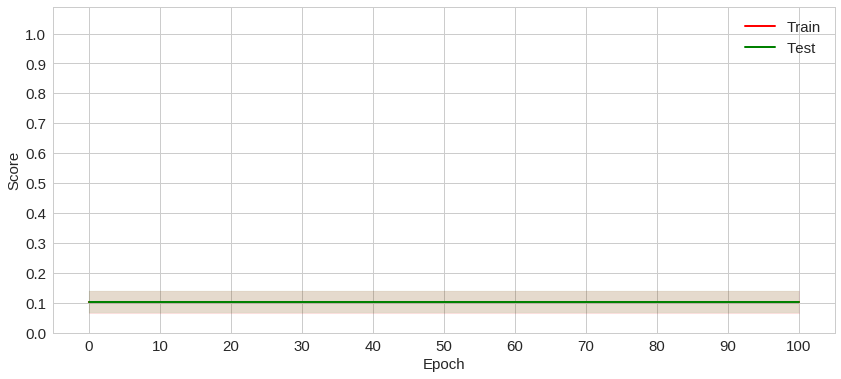

In [37]:
plot_mean_acc(hist)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

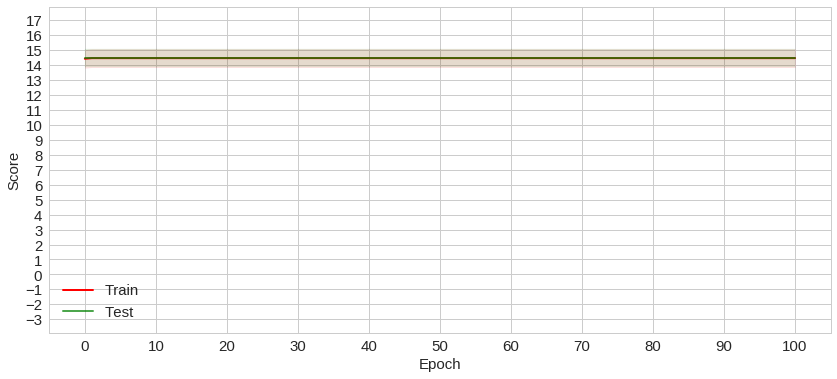

In [39]:
plot_mean_loss(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-13, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="upper left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="upper right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

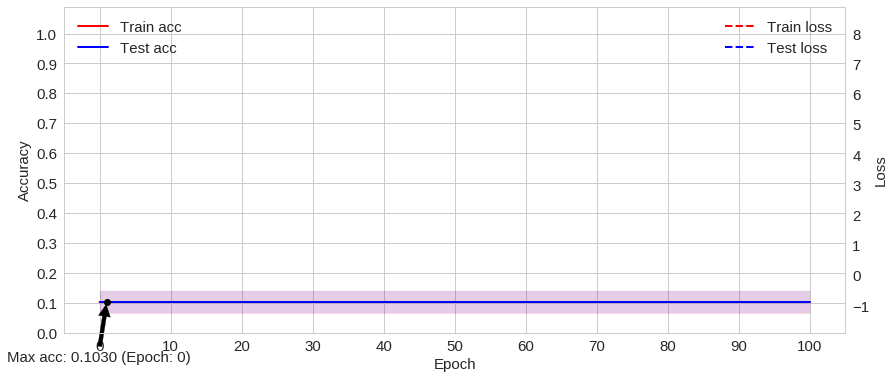

In [41]:
plot_mean(hist)